# Image analysis with Python
This notebook provides an image analysis for various kinds of cultural heritage / museum images.
It is based on the following tutorials and discussions:

**[1]** https://towardsdatascience.com/building-an-image-color-analyzer-using-python-12de6b0acf74 \
**[2]** https://stackoverflow.com/questions/13613573/how-to-speed-up-color-clustering-in-opencv \
**[3]** https://medium.com/codex/rgb-to-color-names-in-python-the-robust-way-ec4a9d97a01f \
**[4]** https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder 

This notebook provides analyses for the CH images we got from Coding da Vinci. It preparats the images for our IR feature as well as it gives detailed explainations about the concepts behind. See at the end of the notebook for answers to questions regarding the concepts if you wonder about our idea.


In [ ]:
import extcolors

# plot color distribution
import matplotlib.pyplot as plt
import numpy as np

# path 
import PIL

# other
from tqdm import tqdm

from webcolors import (
    CSS3_HEX_TO_NAMES,
    hex_to_rgb,
)
from scipy.spatial import KDTree
import extcolors

import matplotlib.pyplot as plt
from scipy.stats import zipf

import os
from tqdm import tqdm


#### Data
We work with OpenGLAM data. This maens we use data that is free for reuse licences by the institutions that give it. Our following image data is especially taken from the context of Coding da Vinci. All data sets were published there and licensed freely for reuse with the purpose to engage tech and culture communities to work with the data. 
We will get our data per URL. [6]

Please load the following folders into the image subdirectory of this repository:
- folder name "westmuensterland": https://download.codingdavinci.de/index.php/s/y7wHa8r6dWtnTTm?path=%2F -- This is the most homogenous of our datasets, containing XXX images of lamps from the XXX museum, which are fotografed in the sammer manner. [Bild]
- folder name "saarlandmuseum": https://download.codingdavinci.de/index.php/s/3y5dXdFAmGxAGgzhttps://download.codingdavinci.de/index.php/s/3y5dXdFAmGxAGgz
- folder name "muenchen":

Since Cultural Heritage images are mostly provided in high resolution for reusing purposes, we directly preprocess them when loading them from the folder and save only the preprocessed (and therefore downsized) images.

#### Color analysis
After preprocessing we perform the color analysis. Since we will later map the colors values to their closest colour name in CSS3 style we use RGB values for that.
[1] provides us with a plot of the color analysis, which we will use for demonstration purposes but what will be not necessary for the future large-scale analysis.
The code originally belongs to [4].

In [ ]:
# Farbkreis von Johannes Itten: http://www.spectrumcolors.de/cor_itten_farbkreis.php
# Problem: Bildet keine sehr hellen / sehr dunklen Farben ab, die werden alle zu Weiß/Schwarz/Grau
itten_colors = {
    'Rot' : ['Red', 'Tomato', 'Crimson', 'DarkRed', 'Firebrick', 'IndianRed', 'LightCoral', 'OrangeRed'],
    'Violett' : ['Plum', 'Purple', 'RebeccaPurple', 'SlateBlue', 'Thistle', 'Violet', 'Orchid', 'MediumSlateBlue', 'MediumPurple','BlueViolet', 'DarkMagenta', 'DarkOrchid', 'DarkViolet', 'Indigo', 'Lavender', 'MediumOrchid'],
    'Blau' : ['PowderBlue', 'RoyalBlue', 'SkyBlue', 'SteelBlue', 'Navy', 'MidnightBlue', 'MediumBlue','LightSkyBlue','AliceBlue', 'Aquamarine', 'Azure', 'Blue', 'CornflowerBlue', 'DarkBlue', 'DarkSlateBlue', 'DeepSkyBlue', 'DodgerBlue', 'LightBlue', 'LightCyan'],
    'Grün' : ['PaleGreen', 'SeaGreen', 'SpringGreen', 'YellowGreen', 'Olive', 'OliveDrab', 'MediumSpringGreen', 'MediumSeaGreen', 'Lime', 'LimeGreen', 'LightGreen', 'Chartreuse', 'DarkGreen', 'DarkKhaki', 'DarkOliveGreen', 'DarkSeaGreen', 'ForestGreen', 'Green', 'GreenYellow', 'LawnGreen'],
    'Gelb' : ['PaleGoldenRod', 'Yellow', 'Khaki', 'LemonChiffon', 'LightGoldenRodYellow'],
    'Orange' : ['Coral', 'DarkOrange', 'DarkSalmon', 'LightSalmon', 'NavajoWhite', 'Orange'],
    #additionally
    'Schwarz' : ['Black'],
    'Weiß' : ['White'],
    'Grau' : ['Snow','WhiteSmoke', 'SeaShell', 'Cornsilk', 'FloralWhite', 'GhostWhite', 'HoneyDew', 'Ivory', 'LightYellow', 'Linen', 'OldLace', 'PapayaWhip', 'Silver', 'SlateGrey', 'SlateGray', 'LightSteelBlue', 'DarkGrey', 'DarkGray', 'DarkSlateGrey', 'DarkSlateGray', 'LightSlateGrey', 'LightSlateGray', 'DimGrey', 'DimGray', 'Gainsboro', 'Grey', 'Gray', 'LightGray', 'LightGrey'],
    'Metallic' : ['DarkGoldenRod', 'Gold', 'GoldenRod', 'Golden', 'Copper', 'Silver'],
    'Braun' : ['PeachPuff', 'SandyBrown', 'Peru', 'SaddleBrown', 'Sienna', 'Tan', 'Wheat', 'AntiqueWhite', 'Beige', 'Bisque', 'BlanchedAlmond', 'Brown', 'BurlyWood', 'Chocolate', 'Maroon', 'Moccasin'],
    'Türkis-Blaugrün': ['PaleTurquoise','Teal', 'Turquoise', 'MintCream', 'Aqua', 'CadetBlue', 'Cyan', 'DarkCyan', 'DarkTurquoise', 'LightSeaGreen', 'MediumAquaMarine', 'MediumTurquoise'],
    'Pink-Rosa': ['PaleVioletRed', 'Pink', 'RosyBrown', 'Salmon', 'DeepPink', 'Fuchsia', 'Hotpink', 'LavenderBlush', 'LightPink', 'Magenta', 'MediumVioletRed', 'MistyRose']
}

In [ ]:
# modified version of: (TO DO) with mapping on less color names and German color names
def convert_rgb_to_names(rgb_tuple):
    # TO DO: fix the lila/magenta issue
    colors = CSS3_HEX_TO_NAMES
    names = []
    rgb_values = []
    for color, color_name in colors.items():
        names.append(color_name)
        rgb_values.append(hex_to_rgb(color))
    
    names.append('golden')
    rgb_values.append((142,120,81))
    names.append('copper')
    rgb_values.append((92,64,50))
    names.append('silver')
    rgb_values.append((153,144,139))

    kdt_db = KDTree(rgb_values,200)    
    distance, index = kdt_db.query(rgb_tuple)
    css_name = names[index]
    
    for value in itten_colors.values():
        for color in value:
            index = list(itten_colors.values()).index(value)
            if color.lower() == css_name: return list(itten_colors.keys())[index]

For color analysis we used two different approaches:
- k-means: which divides the image in five clusters and gives back the dominant color of each cluster
- `extcolors`: which is a packe providing the `extract_from_image`-function that gives back the RGB-value for each pixel of the file
As one can see for the example below k-means needs prepared (reshaped) images and is much slower on the original file size. Since we will work with many high-resolution images we will use 'extcolors`. 
Both algorithms are much faster on resized images (e.g. down-scaling to 50 percent of the original size).

*Example*

In [ ]:
def color_analysis_ext(image_path, file_path, from_path: bool):
    if from_path:
        colors, pixel_count = extcolors.extract_from_path(image_path, 8)
    else:
        colors, pixel_count = extcolors.extract_from_image(image_path, 8)
    colors = dict(colors)
    
    names = {} # dict is last-wins, so values will be overwritten when duplicate
    for (key, value) in colors.items():
        temp = (value/sum(colors.values()))*100
        key_name = convert_rgb_to_names(key)
        if key_name in names: 
            names[key_name] = names[key_name] + temp
        else: 
            names[key_name] = temp
    names = {k: v for k, v in sorted(names.items(), key=lambda item: item[1], reverse = True)}
    file = open(file_path, "w+")
    for key,value in names.items():
        line = ""
        for i in range (1,int(value)):
            line += str(key) + ' '
        file.write(line + "\n")
    return names     


In [ ]:
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt", 1)
lst = list(data.items())
#https://stackoverflow.com/questions/61582631/how-to-add-a-zipf-curve-to-a-bar-plot-of-word-frequency
plt.bar([key for key, val in lst], [val for key, val in lst])
alpha = 1.37065874
total = sum([value for key, value in lst])
plt.plot(range(len(lst)), [zipf.pmf(p, alpha) * total for p in range(1, len(lst) + 1)], color='black')
plt.xticks(rotation='vertical')
plt.xlabel('Farbname')
plt.ylabel('Häufigkeit in %')
plt.show()

In [ ]:
data

## Over-engineered on this image, copper always mapped to green and gold to violet

In [ ]:
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt", 1)
lst = list(data.items())
#https://stackoverflow.com/questions/61582631/how-to-add-a-zipf-curve-to-a-bar-plot-of-word-frequency
alpha = 1.6
plt.bar([key for key, val in lst], [val for key, val in lst])
alpha = 1.37065874
total = sum([value for key, value in lst])
plt.plot(range(len(lst)), [zipf.pmf(p, alpha) * total for p in range(1, len(lst) + 1)], color='black')
plt.xticks(rotation='vertical')
plt.xlabel('Farbname')
plt.ylabel('Häufigkeit in %')
plt.show()

In [ ]:
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-16-210.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt",1)
lst = list(data.items())
#https://stackoverflow.com/questions/61582631/how-to-add-a-zipf-curve-to-a-bar-plot-of-word-frequency
plt.bar([key for key, val in lst], [val for key, val in lst])
alpha = 2
total = sum([value for key, value in lst])
plt.plot(range(len(lst)), [zipf.pmf(p, alpha) * total for p in range(1, len(lst) + 1)], color='black')
plt.xticks(rotation='vertical')
plt.xlabel('Farbname')
plt.ylabel('Häufigkeit in %')
plt.show()
#diskrete Werte vs einheitenweise Werte

In [ ]:
# Quellen
## https://stackoverflow.com/questions/61582631/how-to-add-a-zipf-curve-to-a-bar-plot-of-word-frequency
## https://stackoverflow.com/questions/10369681/how-to-plot-bar-graphs-with-same-x-coordinates-side-by-side-dodged
## https://stackoverflow.com/questions/36415407/i-cant-figure-out-how-to-set-multi-line-xticklabels-when-reading-labels-from-a
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-16-210.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt",1)

alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')


In [ ]:
img = PIL.Image.open("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg")
width, height = img.size
new_size = (int(width/2), int(height/2))
img = img.resize(new_size)
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt",1)
data2 = color_analysis_ext(img, "C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-44.txt",0)

alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
indices2 = range(len(data2.values()))
width = np.max(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width, data.values(), width, color='blue')
_ = ax.bar(indices2-width, data2.values(), width, color='orange')
_ = ax.bar(indices, [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16, um 0.5 verkleinert vs. erwartete Zipf-Verteilung mit alpha=1.7.')

In [ ]:
img = PIL.Image.open("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg")
width, height = img.size
new_size = (int(width/4), int(height/4))
img = img.resize(new_size)
data = color_analysis_ext("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterland\\HM-17-16.jpg","C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-16.txt",1)
data2 = color_analysis_ext(img, "C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\westmuensterlandtext\\HM-17-44.txt",0)

alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
indices2 = range(len(data2.values()))
width = np.max(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width, data.values(), width, color='blue')
_ = ax.bar(indices2-width, data2.values(), width, color='orange')
_ = ax.bar(indices, [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16, auf 2/3 verkleinert vs. erwartete Zipf-Verteilung mit alpha=1.7.')

So one can see that in one image there is a power law on which the distribution of the colors depend. This varies with the downsizing of the image, which is the resaon why we will try to use the original sized images in the following and why we dropped the k-means approach.
We will now expand the data.

#### Full Analysis

In [ ]:
def analyse_images(folder, file_folder):
    pbar = tqdm(total=len(os.listdir(folder)))
    color_dict_all = dict.fromkeys(itten_colors.keys(),0)
    for filename in os.listdir(folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')): continue
        img = PIL.Image.open(os.path.join(folder, filename))
        width, height = img.size
        new_size = (int(width/4), int(height/4))
        img = img.resize(new_size)
        result = color_analysis_ext(img, os.path.join(file_folder) + "\\" + filename.split('.')[0] + ".txt", 0) 
        for (key,value) in color_dict_all.items():
            if key not in result.keys(): continue
            color_dict_all[key] = value+result[key]
        pbar.update(n=1)
        result = {k: v for k, v in sorted(color_dict_all.items(), key=lambda item: item[1], reverse = True)}
        result = {k: v for k, v in result.items() if v >= 1} # delete colors with 0 percent, since log will not work on log(0). delete also 
        # colors that appear less then 1%
    return result

In [ ]:
import os

data = analyse_images(os.path.join("..", "images", "westmuensterland"), os.path.join("C:", "Users", "LeaGl", "Documents", "GitHub", "InformationRetrieval", "images", "westmuensterlandtext"))

alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')
#plt.savefig("westmuensterland")

In [ ]:
data = analyse_images("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\muenchen", "C:\\Users\\LeaGl\Documents\\GitHub\\InformationRetrieval\\images\\muenchentext")
alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')
#plt.savefig("westmuensterland")

 99%|█████████▉| 254/256 [07:30<00:02,  1.45s/it]

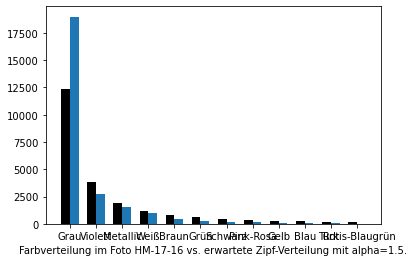

In [14]:
import os

data = analyse_images(os.path.join("..", "images", "westmuensterland"), os.path.join("C:", "Users", "LeaGl", "Documents", "GitHub", "InformationRetrieval", "images", "westmuensterlandtext"))

alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')
#plt.savefig("westmuensterland")





 99%|█████████▉| 254/256 [07:31<00:03,  1.78s/it]




















































































































































































































































































































































































































































































































































































































































































































































































































































































































































































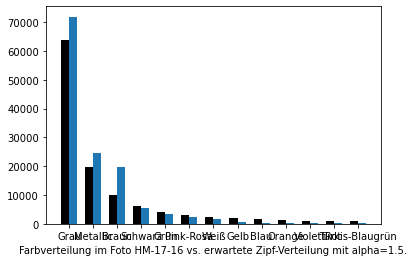

In [15]:
data = analyse_images("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\saarlandmuseum", "C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\saarlandmuseumtext")
alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')
#plt.savefig("westmuensterland")

  0%|          | 1/6758 [00:03<5:39:45,  3.02s/it]c:\Users\LeaGl\anaconda3\lib\site-packages\PIL\Image.py:2837: DecompressionBombWarning: Image size (91440970 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  0%|          | 28/6758 [01:45<6:28:13,  3.46s/it]c:\Users\LeaGl\anaconda3\lib\site-packages\PIL\Image.py:2837: DecompressionBombWarning: Image size (91586500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  1%|          | 39/6758 [02:36<8:09:45,  4.37s/it]c:\Users\LeaGl\anaconda3\lib\site-packages\PIL\Image.py:2837: DecompressionBombWarning: Image size (91740475 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
  1%|          | 40/6758 [02:42<8:52:12,  4.75s/it]c:\Users\LeaGl\anaconda3\lib\site-packages\PIL\Image.py:2837: DecompressionBombWarning: Image size (100021922 pixels) exceeds limit of 89478

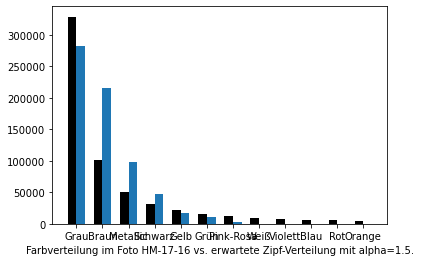

In [16]:
data = analyse_images("C:\\Users\\LeaGl\\Documents\\GitHub\\InformationRetrieval\\images\\muenchen", "C:\\Users\\LeaGl\Documents\\GitHub\\InformationRetrieval\\images\\muenchentext")
alpha = 1.7
total = sum(data.values())

indices = range(len(data.values()))
width = np.min(np.diff(indices))/3.

fig, ax = plt.subplots()
_ = ax.bar(indices+width/2., data.values(), width)
_ = ax.bar(indices-width/2., [zipf.pmf(p, alpha) * total for p in range(1, len(data.values()) + 1)], width, color='black')
_ = ax.set(xticks=indices, xticklabels=data.keys())
_ = ax.set_xlabel('Farbverteilung im Foto HM-17-16 vs. erwartete Zipf-Verteilung mit alpha=1.5.')
#plt.savefig("westmuensterland")